# eQTL Input 

In [3]:
import cPickle
import glob
import gzip
import os
import random
import shutil
import subprocess
import uuid

import cdpybio as cpb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools as pbt
import seaborn as sns
import statsmodels.api as sm
import vcf as pyvcf

import ciepy
import cardipspy as cpy

%matplotlib inline
%load_ext rpy2.ipython

random.seed(20150605)

In [4]:
sns.set_context('notebook')

In [6]:
outdir = os.path.join(ciepy.root, 'output',
                      'eqtl_input')
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output',
                              'eqtl_input')
cpy.makedir(private_outdir)

In [12]:
array_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'array_metadata.tsv'), index_col=0)
wgs_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'wgs_metadata.tsv'), index_col=0, 
                         squeeze=True)
rna_meta = pd.read_table(os.path.join(ciepy.root, 'data', 'rnaseq_metadata.tsv'), index_col=0)

#fn = os.path.join(ciepy.root, 'private_data', 'TableOf280_PedigreeWithUUIDS_forPhasing_V2.xlsx')
#pedigree = pd.read_excel(fn)
#pedigree.index = pedigree['ID']

gene_counts = pd.read_table(os.path.join(ciepy.root, 'data', 'gene_counts.tsv'),
                            index_col=0)
gene_info = pd.read_table('/raid3/publicdata/gencode_v19/gene_info.tsv',
                          index_col=0)
tpm = pd.read_table(os.path.join(ciepy.root, 'data', 'rsem_tpm.tsv'),
                    index_col=0)

In [10]:
%%R

suppressPackageStartupMessages(library(DESeq2))
suppressPackageStartupMessages(library("BiocParallel"))
register(MulticoreParam(30))

## Gene Expression

I'll make normalized counts from DESeq and VST counts. I'll also get counts from RSEM.

### Naive Counts: Library Normalized and VST

### RSEM

TODO

In [13]:
tpm.shape

(57820, 202)

## Variant Regions

I'm going to identify the regions within 1 megabase of the TSSs for each gene whose
variants I want to test.

In [85]:
fn = os.path.join(outdir, 'variant_regions.bed')
if not os.path.exists(fn):
    variant_regions = cpb.gencode.make_promoter_bed(cpy.gencode_gtf, merge_by_gene=True,
                                                   up=1000000, down=1000000, out=fn)
else:
    variant_regions = pbt.BedTool(fn)

In principle, there could be multiple regions per gene if a gene has TSSs located more than
1MB apart. In practice, this doesn't seem to happen.

In [96]:
fn = os.path.join(outdir, 'gene_to_regions.p')
if not os.path.exists(fn):
    gene_to_regions = dict()
    for r in variant_regions:
        gene = r.name.split('_')[0]
        gene_to_regions[gene] = gene_to_regions.get(gene, []) + ['{}:{}-{}'.format(
                r.chrom, r.start, r.end)]
    fn = os.path.join(outdir, 'gene_to_regions.p')
    cPickle.dump(gene_to_regions, open(fn, 'wb') )

## Kinship Matrix

In [8]:
wgs_vcf = os.path.join(ciepy.root, 'private_data', 'wgs', 'biallelic_snvs_pruned_conv.vcf.gz')

wgs_kmatrix = os.path.join(outdir, 'wgs.kin')
if not os.path.exists(wgs_kmatrix):
    c = ('{} make-kin --vcf {} --min-maf 0.01 --min-callrate 0.95 '
         '--out {} --run 10'.format(cpy.epacts, wgs_vcf, wgs_kmatrix))
    subprocess.check_call(c, shell=True)
    
wgs_kdump = os.path.join(outdir, 'wgs.kindump')
if not os.path.exists(wgs_kdump):
    c = ('{}/pEmmax kin-util --kinf {} --outf {} --dump'.format(
        os.path.split(cpy.epacts)[0], wgs_kmatrix, os.path.splitext(wgs_kdump)[0]))
    subprocess.check_call(c, shell=True)
    
wgskmatrix = pd.read_table(wgs_kdump)

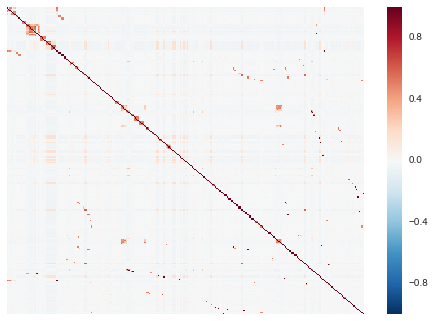

In [9]:
sns.heatmap(wgskmatrix, xticklabels=False, yticklabels=False, linewidths=0);